In [34]:
import os

In [35]:
# silence TF logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [36]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [37]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.decomposition import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

import tensorflow as tf
from tensorflow import keras
# import SciKeras wrapper library
from scikeras.wrappers import KerasClassifier

In [38]:
# set fixed randomness

# random seed for Python hash algorithm and NumPy
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
# set paths for persisting models
MODEL_ON_DISK = 'joblib/part-b.joblib'
validation_folds = 5
CPUs = len(os.sched_getaffinity(0))

In [40]:
print('CPUs:', CPUs)

CPUs: 40


### Load dataset

In [41]:
# load training and testing datasets and set headers
dir = 'data'
dataset_train = pd.read_csv(f'{dir}/TrainingDataMulti.csv', header=None, names=['R1-PA1:VH','R1-PM1:V','R1-PA2:VH','R1-PM2:V','R1-PA3:VH','R1-PM3:V','R1-PA4:IH','R1-PM4:I','R1-PA5:IH','R1-PM5:I','R1-PA6:IH','R1-PM6:I','R1-PA7:VH','R1-PM7:V','R1-PA8:VH','R1-PM8:V','R1-PA9:VH','R1-PM9:V','R1-PA10:IH','R1-PM10:I','R1-PA11:IH','R1-PM11:I','R1-PA12:IH','R1-PM12:I','R1:F','R1:DF','R1-PA:Z','R1-PA:ZH','R1:S','R2-PA1:VH','R2-PM1:V','R2-PA2:VH','R2-PM2:V','R2-PA3:VH','R2-PM3:V','R2-PA4:IH','R2-PM4:I','R2-PA5:IH','R2-PM5:I','R2-PA6:IH','R2-PM6:I','R2-PA7:VH','R2-PM7:V','R2-PA8:VH','R2-PM8:V','R2-PA9:VH','R2-PM9:V','R2-PA10:IH','R2-PM10:I','R2-PA11:IH','R2-PM11:I','R2-PA12:IH','R2-PM12:I','R2:F','R2:DF','R2-PA:Z','R2-PA:ZH','R2:S','R3-PA1:VH','R3-PM1:V','R3-PA2:VH','R3-PM2:V','R3-PA3:VH','R3-PM3:V','R3-PA4:IH','R3-PM4:I','R3-PA5:IH','R3-PM5:I','R3-PA6:IH','R3-PM6:I','R3-PA7:VH','R3-PM7:V','R3-PA8:VH','R3-PM8:V','R3-PA9:VH','R3-PM9:V','R3-PA10:IH','R3-PM10:I','R3-PA11:IH','R3-PM11:I','R3-PA12:IH','R3-PM12:I','R3:F','R3:DF','R3-PA:Z','R3-PA:ZH','R3:S','R4-PA1:VH','R4-PM1:V','R4-PA2:VH','R4-PM2:V','R4-PA3:VH','R4-PM3:V','R4-PA4:IH','R4-PM4:I','R4-PA5:IH','R4-PM5:I','R4-PA6:IH','R4-PM6:I','R4-PA7:VH','R4-PM7:V','R4-PA8:VH','R4-PM8:V','R4-PA9:VH','R4-PM9:V','R4-PA10:IH','R4-PM10:I','R4-PA11:IH','R4-PM11:I','R4-PA12:IH','R4-PM12:I','R4:F','R4:DF','R4-PA:Z','R4-PA:ZH','R4:S','control_panel_log1','control_panel_log2','control_panel_log3','control_panel_log4','relay1_log','relay2_log','relay3_log','relay4_log','snort_log1','snort_log2','snort_log3','snort_log4','marker'])
dataset_test = pd.read_csv(f'{dir}/TestingDataMulti.csv', header=None, names=['R1-PA1:VH','R1-PM1:V','R1-PA2:VH','R1-PM2:V','R1-PA3:VH','R1-PM3:V','R1-PA4:IH','R1-PM4:I','R1-PA5:IH','R1-PM5:I','R1-PA6:IH','R1-PM6:I','R1-PA7:VH','R1-PM7:V','R1-PA8:VH','R1-PM8:V','R1-PA9:VH','R1-PM9:V','R1-PA10:IH','R1-PM10:I','R1-PA11:IH','R1-PM11:I','R1-PA12:IH','R1-PM12:I','R1:F','R1:DF','R1-PA:Z','R1-PA:ZH','R1:S','R2-PA1:VH','R2-PM1:V','R2-PA2:VH','R2-PM2:V','R2-PA3:VH','R2-PM3:V','R2-PA4:IH','R2-PM4:I','R2-PA5:IH','R2-PM5:I','R2-PA6:IH','R2-PM6:I','R2-PA7:VH','R2-PM7:V','R2-PA8:VH','R2-PM8:V','R2-PA9:VH','R2-PM9:V','R2-PA10:IH','R2-PM10:I','R2-PA11:IH','R2-PM11:I','R2-PA12:IH','R2-PM12:I','R2:F','R2:DF','R2-PA:Z','R2-PA:ZH','R2:S','R3-PA1:VH','R3-PM1:V','R3-PA2:VH','R3-PM2:V','R3-PA3:VH','R3-PM3:V','R3-PA4:IH','R3-PM4:I','R3-PA5:IH','R3-PM5:I','R3-PA6:IH','R3-PM6:I','R3-PA7:VH','R3-PM7:V','R3-PA8:VH','R3-PM8:V','R3-PA9:VH','R3-PM9:V','R3-PA10:IH','R3-PM10:I','R3-PA11:IH','R3-PM11:I','R3-PA12:IH','R3-PM12:I','R3:F','R3:DF','R3-PA:Z','R3-PA:ZH','R3:S','R4-PA1:VH','R4-PM1:V','R4-PA2:VH','R4-PM2:V','R4-PA3:VH','R4-PM3:V','R4-PA4:IH','R4-PM4:I','R4-PA5:IH','R4-PM5:I','R4-PA6:IH','R4-PM6:I','R4-PA7:VH','R4-PM7:V','R4-PA8:VH','R4-PM8:V','R4-PA9:VH','R4-PM9:V','R4-PA10:IH','R4-PM10:I','R4-PA11:IH','R4-PM11:I','R4-PA12:IH','R4-PM12:I','R4:F','R4:DF','R4-PA:Z','R4-PA:ZH','R4:S','control_panel_log1','control_panel_log2','control_panel_log3','control_panel_log4','relay1_log','relay2_log','relay3_log','relay4_log','snort_log1','snort_log2','snort_log3','snort_log4'])

### Exploratory data analysis

In [42]:
print(dataset_train.columns)
print('features:', len(dataset_train.columns))
print('features:', len(dataset_test.columns))

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log',
       'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4',
       'marker'],
      dtype='object', length=129)
features: 129
features: 128


In [43]:
dataset_train.head()

,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,R1-PA6:IH,R1-PM6:I,R1-PA7:VH,R1-PM7:V,R1-PA8:VH,R1-PM8:V,R1-PA9:VH,R1-PM9:V,R1-PA10:IH,R1-PM10:I,R1-PA11:IH,R1-PM11:I,R1-PA12:IH,R1-PM12:I,R1:F,R1:DF,R1-PA:Z,R1-PA:ZH,R1:S,R2-PA1:VH,R2-PM1:V,R2-PA2:VH,R2-PM2:V,R2-PA3:VH,R2-PM3:V,R2-PA4:IH,R2-PM4:I,R2-PA5:IH,R2-PM5:I,R2-PA6:IH,R2-PM6:I,R2-PA7:VH,R2-PM7:V,R2-PA8:VH,R2-PM8:V,R2-PA9:VH,R2-PM9:V,R2-PA10:IH,R2-PM10:I,R2-PA11:IH,R2-PM11:I,R2-PA12:IH,R2-PM12:I,R2:F,R2:DF,R2-PA:Z,R2-PA:ZH,R2:S,R3-PA1:VH,R3-PM1:V,R3-PA2:VH,R3-PM2:V,R3-PA3:VH,R3-PM3:V,R3-PA4:IH,R3-PM4:I,R3-PA5:IH,R3-PM5:I,R3-PA6:IH,R3-PM6:I,R3-PA7:VH,R3-PM7:V,R3-PA8:VH,R3-PM8:V,R3-PA9:VH,R3-PM9:V,R3-PA10:IH,R3-PM10:I,R3-PA11:IH,R3-PM11:I,R3-PA12:IH,R3-PM12:I,R3:F,R3:DF,R3-PA:Z,R3-PA:ZH,R3:S,R4-PA1:VH,R4-PM1:V,R4-PA2:VH,R4-PM2:V,R4-PA3:VH,R4-PM3:V,R4-PA4:IH,R4-PM4:I,R4-PA5:IH,R4-PM5:I,R4-PA6:IH,R4-PM6:I,R4-PA7:VH,R4-PM7:V,R4-PA8:VH,R4-PM8:V,R4-PA9:VH,R4-PM9:V,R4-PA10:IH,R4-PM10:I,R4-PA11:IH,R4-PM11:I,R4-PA12:IH,R4-PM12:I,R4:F,R4:DF,R4-PA:Z,R4-PA:ZH,R4:S,control_panel_log1,control_panel_log2,control_panel_log3,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4,marker
0,70.399324,127673.0908,-49.572308,127648.0176,-169.578319,127723.2374,65.689611,605.91099,-57.003571,626.78553,-173.589023,602.43190,70.422243,127673.0908,0.0,0.0,0.0,0.0,65.007791,611.58740,118.567886,13.18392,-100.869220,13.91636,59.999,0.01,6.391383,0.076290,0,60.658268,124631.8125,-59.295959,124484.3594,-179.338078,124715.0703,-119.550481,612.796753,117.726753,632.532105,0.859680,610.141724,60.680241,124611.9844,0.0,0.0,0.0,0.0,-120.341499,618.301392,-64.053043,12.765884,69.397891,12.828827,59.999001,0.02,6.130100,3.135101,0,60.664771,124187.9063,-59.312591,124162.8330,-179.301412,124212.9796,-119.753909,610.12252,117.685531,628.25041,0.658901,606.82654,60.687690,124187.9063,0.0,0.0,0.0,0.0,-120.487295,614.88338,-64.812986,12.08526,70.387865,11.90215,59.999,0.02,6.111440,3.140520,0,70.450890,127723.2374,-49.537931,127096.4056,-169.532482,127773.3839,65.643775,604.44611,-56.871791,621.84156,-173.869773,599.86836,70.462350,127522.6512,0.0,0.0,0.0,0.0,64.950496,608.47453,119.301272,12.26837,-102.060972,11.71904,59.999,0.01,6.341832,0.077897,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,73.688102,130280.7109,-46.300719,130255.6377,-166.278082,130355.9307,71.831719,483.59351,-50.947407,500.98896,-167.487023,481.39619,73.705291,130305.7842,0.0,0.0,0.0,0.0,71.109792,488.35437,125.792884,10.62038,-95.884487,11.35282,60.005,0.00,8.185463,0.024924,0,66.069035,128277.4297,-53.885193,128126.3047,-173.932803,128354.7578,-114.925241,489.349365,122.148740,505.754456,5.468445,487.335205,66.085509,128251.6250,0.0,0.0,0.0,0.0,-115.787662,493.978516,-59.669496,10.797501,72.424621,10.808945,60.005001,0.00,7.924891,-3.136669,0,66.062034,127823.5305,-53.909599,127798.4572,-173.892691,127848.6037,-115.124410,487.07260,122.125954,502.08762,5.259753,484.32595,66.090682,127823.5305,0.0,0.0,0.0,0.0,-115.932280,491.10102,-60.172028,10.25416,73.533403,10.07105,60.005,0.00,7.898427,-3.131062,0,73.745398,130330.8575,-46.249153,129704.0257,-166.232245,130381.0040,71.837448,481.76241,-50.792709,496.04499,-167.618803,477.73399,73.756857,130130.2713,0.0,0.0,0.0,0.0,71.121251,485.05839,124.274546,10.25416,-95.454769,9.70483,60.005,0.00,8.141328,0.027210,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,73.733939,130305.7842,-46.254883,130280.7109,-166.232245,130381.0040,71.808800,483.59351,-50.913030,500.98896,-167.441186,481.02997,73.751127,130330.8575,0.0,0.0,0.0,0.0,71.132710,488.35437,125.007932,10.62038,-94.520847,11.35282,60.005,0.00,8.190006,0.027904,0,66.112980,128283.9453,-53.852234,128144.4688,-173.883366,128382.9609,-114.919736,488.885864,122.214665,505.531311,5.462952,487.627014,66.129454,128269.5938,0.0,0.0,0.0,0.0,-115.765696,493.852600,-58.653259,10.396957,72.177430,10.768890,60.005001,0.00,7.931677,-3.136360,0,66.119330,127823.5305,-53.863762,127798.4572,-1

In [44]:
dataset_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 129 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    R1-PA1:VH           6000 non-null   float64
 1    R1-PM1:V            6000 non-null   float64
 2    R1-PA2:VH           6000 non-null   float64
 3    R1-PM2:V            6000 non-null   float64
 4    R1-PA3:VH           6000 non-null   float64
 5    R1-PM3:V            6000 non-null   float64
 6    R1-PA4:IH           6000 non-null   float64
 7    R1-PM4:I            6000 non-null   float64
 8    R1-PA5:IH           6000 non-null   float64
 9    R1-PM5:I            6000 non-null   float64
 10   R1-PA6:IH           6000 non-null   float64
 11   R1-PM6:I            6000 non-null   float64
 12   R1-PA7:VH           6000 non-null   float64
 13   R1-PM7:V            6000 non-null   float64
 14   R1-PA8:VH           6000 non-null   float64
 15   R1-PM8:V            6000 non-null   

In [45]:
# get columns with any NaN values
print('columns with NaN:', dataset_train.columns[dataset_train.isnull().any()])
print('in target?', dataset_train[['marker']].isnull().any().to_string())

columns with NaN: Index([], dtype='object')
in target? marker    False


In [46]:
dataset_test.head()

,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,R1-PA6:IH,R1-PM6:I,R1-PA7:VH,R1-PM7:V,R1-PA8:VH,R1-PM8:V,R1-PA9:VH,R1-PM9:V,R1-PA10:IH,R1-PM10:I,R1-PA11:IH,R1-PM11:I,R1-PA12:IH,R1-PM12:I,R1:F,R1:DF,R1-PA:Z,R1-PA:ZH,R1:S,R2-PA1:VH,R2-PM1:V,R2-PA2:VH,R2-PM2:V,R2-PA3:VH,R2-PM3:V,R2-PA4:IH,R2-PM4:I,R2-PA5:IH,R2-PM5:I,R2-PA6:IH,R2-PM6:I,R2-PA7:VH,R2-PM7:V,R2-PA8:VH,R2-PM8:V,R2-PA9:VH,R2-PM9:V,R2-PA10:IH,R2-PM10:I,R2-PA11:IH,R2-PM11:I,R2-PA12:IH,R2-PM12:I,R2:F,R2:DF,R2-PA:Z,R2-PA:ZH,R2:S,R3-PA1:VH,R3-PM1:V,R3-PA2:VH,R3-PM2:V,R3-PA3:VH,R3-PM3:V,R3-PA4:IH,R3-PM4:I,R3-PA5:IH,R3-PM5:I,R3-PA6:IH,R3-PM6:I,R3-PA7:VH,R3-PM7:V,R3-PA8:VH,R3-PM8:V,R3-PA9:VH,R3-PM9:V,R3-PA10:IH,R3-PM10:I,R3-PA11:IH,R3-PM11:I,R3-PA12:IH,R3-PM12:I,R3:F,R3:DF,R3-PA:Z,R3-PA:ZH,R3:S,R4-PA1:VH,R4-PM1:V,R4-PA2:VH,R4-PM2:V,R4-PA3:VH,R4-PM3:V,R4-PA4:IH,R4-PM4:I,R4-PA5:IH,R4-PM5:I,R4-PA6:IH,R4-PM6:I,R4-PA7:VH,R4-PM7:V,R4-PA8:VH,R4-PM8:V,R4-PA9:VH,R4-PM9:V,R4-PA10:IH,R4-PM10:I,R4-PA11:IH,R4-PM11:I,R4-PA12:IH,R4-PM12:I,R4:F,R4:DF,R4-PA:Z,R4-PA:ZH,R4:S,control_panel_log1,control_panel_log2,control_panel_log3,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4
0,-100.141563,132336.7191,139.881916,132311.6458,19.875906,132411.9389,-90.590357,231.45104,142.431578,254.33979,30.143310,230.35238,-100.124375,132361.7923,0.0,0.0,0,0,-92.830622,238.22611,-30.882425,12.81770,96.978836,13.18392,60.000,0.0,19.226201,-0.201970,0,-103.999329,131760.9063,136.051945,131611.3906,16.004334,131849.4375,75.456850,236.715317,-51.094668,258.533478,-163.742980,233.808518,-103.977356,131740.8281,0.0,0.0,0,0,73.396912,242.603302,134.579780,12.834549,-94.007268,12.531281,60.000000,0.0,18.507022,3.127529,0,-103.997569,131308.7150,136.037369,131258.5685,16.042818,131308.7150,75.200711,235.47946,-51.021892,256.17089,-163.991980,231.81726,-103.974651,131283.6417,0.0,0.0,0,0,73.264113,240.78965,134.158068,12.45148,-92.567061,11.71904,60.0,0.0,18.389303,3.138505,0,-100.072809,132386.8656,139.944942,131760.0339,19.944661,132462.0854,-90.848188,230.90171,142.758164,252.32558,29.971422,228.15506,-100.061349,132211.3527,0.0,0.0,0,0,-92.847811,236.76123,-31.065772,12.26837,100.416583,12.08526,60.000,0.0,19.047337,-0.181820,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-100.267614,132311.6458,139.732947,132311.6458,19.738396,132411.9389,-92.280582,236.94434,141.944564,255.43845,28.367140,236.39501,-100.261885,132336.7191,0.0,0.0,0,0,-94.091129,242.62075,-33.581056,10.43727,94.486470,10.98660,60.000,0.0,18.160567,-0.169329,0,-104.142155,131756.3438,135.914617,131610.8594,15.872497,131844.6875,73.693547,242.912293,-51.457214,259.328857,-165.566723,240.411758,-104.114691,131736.8125,0.0,0.0,0,0,72.138976,247.289658,130.981759,10.128021,-95.847478,9.922028,60.000000,0.0,17.360403,-3.121405,0,-104.135079,131283.6417,135.899859,131258.5685,15.899579,131308.7150,73.464648,241.15587,-51.428692,256.72022,-165.831175,238.59233,-104.106431,131283.6417,0.0,0.0,0,0,71.992147,245.18429,130.989611,9.70483,-95.191208,9.33861,60.0,0.0,17.317084,-3.114870,0,-100.204589,132386.8656,139.795972,131760.0339,19.801421,132462.0854,-92.412363,236.02879,142.328446,253.24113,28.286926,234.01458,-100.198859,132186.2794,0.0,0.0,0,0,-94.022374,240.97276,-33.414899,10.07105,98.239344,10.07105,60.000,0.0,18.049762,-0.154024,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-100.301992,132336.7191,139.710029,132286.5725,19.726937,132411.9389,-92.589980,237.67678,141.881539,255.43845,28.069202,237.67678,-100.284803,132336.7191,0.0,0.0,0,0,-94.303124,243.35319,-33.856076,9.88794,93.386391,10.80349,59.999,0.0,18.017815,-0.164832,0,-104.153138,131757.5156,135.892638,131613.0625,15.845031,131842.8750,73.484803,243.661881,-51.506655,259.202942,-165.841378,240.852356,-104.136664,131737.4375,0.0,0.0,0,0,71.963201,247.655869,130.531308,9.876251,-95.891423,9.452820,60.000000,0.0,17.196530,-3.116721,0,-104.157998,131283.6417,135.871212,131283.6417,15.893849,131308.7150,73.436001,241.88831,-51

In [47]:
counts = dataset_train[['marker']].value_counts()
labels = counts.index
sizes = counts.values

print('classes:\n', counts, sep='')
print('classes (%):\n', dataset_train[['marker']].value_counts(normalize=True).mul(100).round(2).astype(str)+'%', sep='')

classes:
marker
0         3000
1         1500
2         1500
Name: count, dtype: int64
classes (%):
marker
0         50.0%
1         25.0%
2         25.0%
Name: proportion, dtype: object


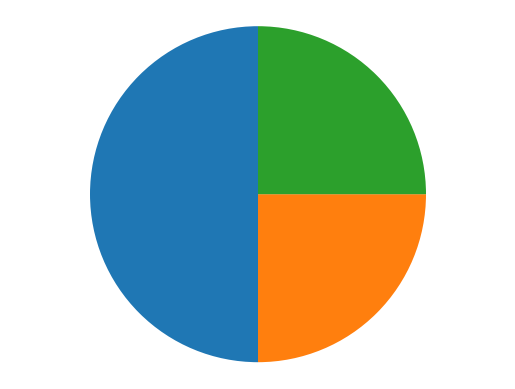

In [48]:
# plot training set class proportions
plt.figure()
plt.pie(sizes, startangle=90)
plt.axis('equal')

plt.savefig('img/dataset_train-classes-multi.pdf', format="pdf")

#### Duplicates

In [49]:
%%time
# count the number of duplicated rows
duplicates = dataset_train.duplicated()
num_duplicates = duplicates.sum()

print('There are', num_duplicates, 'duplicated rows in the dataset')

There are 0 duplicated rows in the dataset
CPU times: user 31.2 ms, sys: 191 µs, total: 31.4 ms
Wall time: 30.8 ms


In [50]:
# shuffle the dataset to make sure there's no inherent order from when the dataset was prepared
dataset_train = dataset_train.sample(frac=1, random_state=42)

In [51]:
y_train = dataset_train[['marker']]
X_train = dataset_train.drop(dataset_train.columns[128], axis=1)

In [52]:
print('X_train features:', len(X_train.columns), 'y_train features:', len(y_train.columns))

X_train features: 128 y_train features: 1


### ML pipeline

In [53]:
# code adapted from https://adriangb.com/scikeras/stable/quickstart.html
class KerasMLPClassifier(KerasClassifier):
    
    def __init__(
        self,
        hidden_layer_sizes=(100, ),
        optimizer="adam",
        optimizer__learning_rate=0.001,
        epochs=200,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.optimizer = optimizer
        self.epochs = epochs
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs):
        model = keras.Sequential()
        inp = keras.layers.Input(shape=(self.n_features_in_))
        model.add(inp)
        for hidden_layer_size in self.hidden_layer_sizes:
            layer = keras.layers.Dense(hidden_layer_size, activation="relu")
            model.add(layer)
        if self.target_type_ == "binary":
            n_output_units = 1
            output_activation = "sigmoid"
            loss = "binary_crossentropy"
        elif self.target_type_ == "multiclass":
            n_output_units = self.n_classes_
            output_activation = "softmax"
            loss = "sparse_categorical_crossentropy"
        else:
            raise NotImplementedError(f"Unsupported task type: {self.target_type_}")
        out = keras.layers.Dense(n_output_units, activation=output_activation)
        model.add(out)
        model.compile(loss=loss, optimizer=compile_kwargs["optimizer"], metrics=compile_kwargs["metrics"])
        
        return model

In [54]:
# create pipeline design with components to be replaced as needd during automated model selection & hyper-parameter search
pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('feature_selection', VarianceThreshold(threshold=0)),
    ('dimensionality_reduction', PCA(n_components='mle', random_state=42)),
    ('classifier', LogisticRegression()) # a placeholder
])

#### Automatic model selection and hyperparameter tuning

In [22]:
# model and corresponding hyper-parameter candidates
param_grid = [
    # {  # Logistic Regression
    #     'feature_scaling': [StandardScaler()],
    #     'feature_selection': [VarianceThreshold(threshold=0)],
    #     'classifier': [LogisticRegression(max_iter=5000, n_jobs=CPUs, random_state=42)],
    #     'classifier__C': [1, 10, 100]
    # },
    # {  # Decision Tree
    #     'feature_scaling': [None],
    #     'feature_selection': [VarianceThreshold(threshold=0)],
    #     'dimensionality_reduction': [None],
    #     'classifier': [DecisionTreeClassifier(random_state=42)],
    #     'classifier__min_impurity_decrease': [0, 0.01],
    #     'classifier__criterion': ['gini', 'log_loss']
    # },
    {  #  K-nearest neighbors
        'feature_scaling': [StandardScaler()],  # tried [RobustScaler()]
        'feature_selection': [VarianceThreshold(threshold=0)],
        'dimensionality_reduction': [NeighborhoodComponentsAnalysis(random_state=42)],
        'classifier': [KNeighborsClassifier(n_jobs=CPUs)],
        'classifier__n_neighbors': [3, 4],  # tried [2, 5, 6, 10]
        'classifier__algorithm': ['auto']
    },
    # {  # Support Vector Machine
    #     'feature_scaling': [RobustScaler()],
    #     'feature_selection': [VarianceThreshold(threshold=0)],
    #     'dimensionality_reduction': [None, PCA(n_components='mle', random_state=42)],
    #     'classifier': [SVC(random_state=42, cache_size=400)],
    #     'classifier__kernel': ['linear', 'rbf'],  # tried ['poly','sigmoid']
    #     # 'classifier__degree': [3, 4],
    #     'classifier__C': [1, 5, 10, 100]  # tried [10,8]
    # },
    # {  # Random Forest
    #     'feature_scaling': [None],
    #     'feature_selection': [VarianceThreshold(threshold=0)],
    #     'dimensionality_reduction': [None],
    #     'classifier': [RandomForestClassifier(random_state=42, n_jobs=CPUs)],
    # },
    # {  # AdaBoost
    #     'feature_scaling': [None],
    #     'feature_selection': [VarianceThreshold(threshold=0)],
    #     'dimensionality_reduction': [None],
    #     'classifier': [AdaBoostClassifier(random_state=42)],
    #     'classifier__estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)],
    # },
    {  # Shallow/Deep Neural Network
        'feature_scaling': [StandardScaler()],  # tried [RobustScaler(), StandardScaler(), None, Normalizer()]
        'feature_selection': [VarianceThreshold(threshold=0)],
        'dimensionality_reduction': [PCA(n_components='mle', random_state=42), None],  # tried [None, LinearDiscriminantAnalysis(), PCA(random_state=42)]
        'classifier': [MLPClassifier(random_state=42, max_iter=4500)],
        'classifier__alpha': [0.0001, 0.001, 0.01],
        'classifier__hidden_layer_sizes': [(600,600,600), (300,), (400, 400), (400,), (500,)],  # tried [(100,), (300,300,300,300)]
        'classifier__batch_size': [512, 256, 128, 64],
        'classifier__activation': ['relu','tanh']
    },
    # {  # Shallow/Deep Neural Network (TensorFlow)
    #     'feature_scaling': [StandardScaler()],
    #     'feature_selection': [VarianceThreshold(threshold=0)],
    #     'dimensionality_reduction': [None],
    #     'classifier': [KerasMLPClassifier(random_state=42)],
    #     'classifier__optimizer': ['adam'],
    #     'classifier__hidden_layer_sizes': [(100,), (100,100,100), (200,)],  # tried [(200,200),(100,100)]
    #     'classifier__epochs': [50, 100, 150],
    #     'classifier__batch_size': [64, 128, 256, 512]  # tried [1024]
    # }
]

search = GridSearchCV(estimator=pipeline,
                      param_grid=param_grid,
                      cv=4,
                      n_jobs=CPUs,
                      scoring='f1_macro',
                      error_score='raise',
                      verbose=1)

#### Training

In [23]:
%%time
search.fit(X_train, y_train['marker'])

# persist on disk (make checkpoint, so we don't need to re-run training each time to work with existing model)
dump(search, MODEL_ON_DISK)

print(f"TRAINING accuracy: {search.best_estimator_.score(X_train, y_train['marker']):.3f}")

Fitting 4 folds for each of 242 candidates, totalling 968 fits


TRAINING accuracy: 0.995
CPU times: user 14min 58s, sys: 10min 49s, total: 25min 47s
Wall time: 46min 44s


#### Best estimator

In [24]:
search.best_params_

{'classifier': MLPClassifier(activation='tanh', batch_size=512,
               hidden_layer_sizes=(600, 600, 600), max_iter=4500,
               random_state=42),
 'classifier__activation': 'tanh',
 'classifier__alpha': 0.0001,
 'classifier__batch_size': 512,
 'classifier__hidden_layer_sizes': (600, 600, 600),
 'dimensionality_reduction': PCA(n_components='mle', random_state=42),
 'feature_scaling': StandardScaler(),
 'feature_selection': VarianceThreshold(threshold=0)}

### Evaluation

#### Cross-validation

In [25]:
%%time
scores = cross_val_score(search.best_estimator_, X_train, y_train['marker'], cv=validation_folds, n_jobs=CPUs, scoring='accuracy')
print("VALIDATION accuracy: %0.2f with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
print(scores)

VALIDATION accuracy: 0.93 with a standard deviation of 0.0090
[0.91833333 0.92666667 0.9275     0.9375     0.94416667]
CPU times: user 20.6 ms, sys: 16.2 ms, total: 36.8 ms
Wall time: 1min 59s


#### All metrics report

In [23]:
# because we are not using hold out cross validation, we need to use `cross_val_predict` before `classification_report`
predicted = cross_val_predict(search.best_estimator_, X_train, y_train['marker'], cv=validation_folds, n_jobs=CPUs)

print('CROSS-VALIDATION classification report:\n', classification_report(y_train['marker'], predicted))

CROSS-VALIDATION classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      3000
           1       0.90      0.89      0.90      1500
           2       0.89      0.88      0.89      1500

    accuracy                           0.93      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.93      0.93      0.93      6000



#### Estimators comparison

In [55]:
# load persisted model
search = load(MODEL_ON_DISK)

In [56]:
# inspect all iterations of automatic hyper parameters search of all candidate models
results = pd.DataFrame(search.cv_results_)
results['param_classifier'] = results['param_classifier'].astype(str)
results['rank_test_score'] = results['rank_test_score'].astype(int)

results[results.rank_test_score <= 10].sort_values('rank_test_score').reset_index(drop=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__algorithm,param_classifier__n_neighbors,param_dimensionality_reduction,param_feature_scaling,param_feature_selection,param_classifier__activation,param_classifier__alpha,param_classifier__batch_size,param_classifier__hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,152.273426,21.340663,0.104701,0.014434,"MLPClassifier(activation='tanh', batch_size=51...",NaN,NaN,"PCA(n_components='mle', random_state=42)",StandardScaler(),VarianceThreshold(threshold=0),tanh,0.0001,512,"(600, 600, 600)",{'classifier': MLPClassifier(activation='tanh'...,0.914045,0.933864,0.933792,0.938738,0.930110,0.009489,1
1,80.526417,10.072037,0.046248,0.002789,"MLPClassifier(activation='tanh', batch_size=51...",NaN,NaN,"PCA(n_components='mle', random_state=42)",StandardScaler(),VarianceThreshold(threshold=0),tanh,0.0001,128,"(400, 400)",{'classifier': MLPClassifier(activation='tanh'...,0.911673,0.933464,0.934171,0.938267,0.929394,0.010394,2
2,169.108222,20.303546,0.097949,0.003691,"MLPClassifier(activation='tanh', batch_size=51...",NaN,NaN,"PCA(n_components='mle', random_state=42)",StandardScaler(),VarianceThreshold(threshold=0),tanh,0.001,512,"(600, 600, 600)",{'classifier': MLPClassifier(activation='tanh'...,0.916740,0.922597,0.932756,0.938683,0.927694,0.008549,3
3,85.299578,22.532153,0.052288,0.016932,"MLPClassifier(activation='tanh', batch_size=51...",NaN,NaN,"PCA(n_components='mle', random_state=42)",StandardScaler(),VarianceThreshold(threshold=0),tanh,0.0001,64,"(400, 400)",{'classifier': MLPClassifier(activation='tanh'...,0.907447,0.929825,0.931721,0.939593,0.927147,0.011949,4
4,121.046809,27.148390,0.105473,0.042560,"MLPClassifier(activation='tanh', batch_size=51...",NaN,NaN,"PCA(n_components='mle', random_state=42)",StandardScaler(),VarianceThreshold(threshold=0),tanh,0.01,256,"(600, 600, 600)",{'classifier': MLPClassifier(activation='tanh'...,0.917338,0.930220,0.923028,0.936834,0.926855,0.007351,5
5,137.314877,31.402982,0.090795,0.010035,"MLPClassifier(activation='tanh', batch_size=51...",NaN,NaN,"PCA(n_components='mle', random_state=42)",StandardScaler(),VarianceThreshold(threshold=0),tanh,0.01,512,"(600, 600, 600)",{'classifier': MLPClassifier(activation='tanh'...,0.913952,0.926400,0.928697,0.932680,0.925432,0.006998,6
6,125.317935,11.096575,0.113243,0.025528,"MLPClassifier(activation='tanh', batch_size=51...",NaN,NaN,"PCA(n_components='mle', random_state=42)",StandardScaler(),VarianceThreshold(threshold=0),tanh,0.001,256,"(600, 600, 600)",{'classifier': MLPClassifier(activation='tanh'...,0.899459,0.934852,0.921181,0.941769,0.924315,0.016150,7
7,99.203007,21.966669,0.054148,0.008226,"MLPClassifier(activation='tanh', batch_size=51...",NaN,NaN,"PCA(n_components='mle', random_state=42)",StandardScaler(),VarianceThreshold(threshold=0),tanh,0.001,64,"(400, 400)",{'classifier': MLPClassifier(activation='tanh'...,0.908506,0.918418,0.934961,0.935013,0.924225,0.011319,8
8,72.169879,22.679879,0.039666,0.006951,"MLPClassifier(activation='tanh', batch_size=51...",NaN,NaN,"PCA(n_components='mle', random_state=42)",StandardScaler(),VarianceThreshold(threshold=0),tanh,0.0001,256,"(400, 400)",{'classifier': MLPClassifier(activation='tanh'...,0.911936,0.918663,0.929273,0.936543,0.924104,0.009475,9
9,66.048473,14.795086,0.084418,0.045184,"MLPClassifier(activation='tanh', batch_size=51...",NaN,NaN,"PCA(n_components='mle', random_state=42)",StandardScaler(),VarianceThreshold(threshold=0),tanh,0.01,256,"(400, 400)",{'classifier': MLPClassifier(activation='tanh'...,0.903500,0.924581,0.930231,0.937010,0.923830,0.012535,10


##### SVC

##### MLP

In [57]:
# removed 'param_classifier__epochs'
columns = ['rank_test_score','mean_test_score','std_test_score','param_classifier__hidden_layer_sizes','param_classifier__batch_size','param_classifier__activation','param_dimensionality_reduction', 'param_classifier__alpha', 'param_feature_scaling']
results[results['param_classifier'].str.contains('MLP')][columns].sort_values('rank_test_score').reset_index(drop=True).head(15)

,rank_test_score,mean_test_score,std_test_score,param_classifier__hidden_layer_sizes,param_classifier__batch_size,param_classifier__activation,param_dimensionality_reduction,param_classifier__alpha,param_feature_scaling
0,1,0.930110,0.009489,"(600, 600, 600)",512,tanh,"PCA(n_components='mle', random_state=42)",0.0001,StandardScaler()
1,2,0.929394,0.010394,"(400, 400)",128,tanh,"PCA(n_components='mle', random_state=42)",0.0001,StandardScaler()
2,3,0.927694,0.008549,"(600, 600, 600)",512,tanh,"PCA(n_components='mle', random_state=42)",0.001,StandardScaler()
3,4,0.927147,0.011949,"(400, 400)",64,tanh,"PCA(n_components='mle', random_state=42)",0.0001,StandardScaler()
4,5,0.926855,0.007351,"(600, 600, 600)",256,tanh,"PCA(n_components='mle', random_state=42)",0.01,StandardScaler()
5,6,0.925432,0.006998,"(600, 600, 600)",512,tanh,"PCA(n_components='mle', random_state=42)",0.01,StandardScaler()
6,7,0.924315,0.016150,"(600, 600, 600)",256,tanh,"PCA(n_components='mle', random_state=42)",0.001,StandardScaler()
7,8,0.924225,0.011319,"(400, 400)",64,tanh,"PCA(n_components='mle', random_state=42)",0.001,StandardScaler()
8,9,0.924104,0.009475,"(400, 400)",256,tanh,"PCA(n_components='mle', random_state=42)",0.0001,StandardScaler()
9,10,0.923830,0.012535,"(400, 400)",256,tanh,"PCA(n_components='mle', random_state=42)",0.01,StandardScaler()


##### KNN

In [58]:
columns = ['rank_test_score','mean_test_score','std_test_score','param_classifier__n_neighbors','param_dimensionality_reduction','param_feature_scaling']
results[results['param_classifier'].str.contains('KN')][columns].sort_values('rank_test_score').reset_index(drop=True)

,rank_test_score,mean_test_score,std_test_score,param_classifier__n_neighbors,param_dimensionality_reduction,param_feature_scaling
0,11,0.922866,0.011573,3,NeighborhoodComponentsAnalysis(random_state=42),StandardScaler()
1,122,0.898651,0.013700,4,NeighborhoodComponentsAnalysis(random_state=42),StandardScaler()


### Testing

In [59]:
y_pred = search.best_estimator_.predict(dataset_test)
dataset_test['marker'] = y_pred

In [61]:
dataset_test.head()

,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,R1-PA6:IH,R1-PM6:I,R1-PA7:VH,R1-PM7:V,R1-PA8:VH,R1-PM8:V,R1-PA9:VH,R1-PM9:V,R1-PA10:IH,R1-PM10:I,R1-PA11:IH,R1-PM11:I,R1-PA12:IH,R1-PM12:I,R1:F,R1:DF,R1-PA:Z,R1-PA:ZH,R1:S,R2-PA1:VH,R2-PM1:V,R2-PA2:VH,R2-PM2:V,R2-PA3:VH,R2-PM3:V,R2-PA4:IH,R2-PM4:I,R2-PA5:IH,R2-PM5:I,R2-PA6:IH,R2-PM6:I,R2-PA7:VH,R2-PM7:V,R2-PA8:VH,R2-PM8:V,R2-PA9:VH,R2-PM9:V,R2-PA10:IH,R2-PM10:I,R2-PA11:IH,R2-PM11:I,R2-PA12:IH,R2-PM12:I,R2:F,R2:DF,R2-PA:Z,R2-PA:ZH,R2:S,R3-PA1:VH,R3-PM1:V,R3-PA2:VH,R3-PM2:V,R3-PA3:VH,R3-PM3:V,R3-PA4:IH,R3-PM4:I,R3-PA5:IH,R3-PM5:I,R3-PA6:IH,R3-PM6:I,R3-PA7:VH,R3-PM7:V,R3-PA8:VH,R3-PM8:V,R3-PA9:VH,R3-PM9:V,R3-PA10:IH,R3-PM10:I,R3-PA11:IH,R3-PM11:I,R3-PA12:IH,R3-PM12:I,R3:F,R3:DF,R3-PA:Z,R3-PA:ZH,R3:S,R4-PA1:VH,R4-PM1:V,R4-PA2:VH,R4-PM2:V,R4-PA3:VH,R4-PM3:V,R4-PA4:IH,R4-PM4:I,R4-PA5:IH,R4-PM5:I,R4-PA6:IH,R4-PM6:I,R4-PA7:VH,R4-PM7:V,R4-PA8:VH,R4-PM8:V,R4-PA9:VH,R4-PM9:V,R4-PA10:IH,R4-PM10:I,R4-PA11:IH,R4-PM11:I,R4-PA12:IH,R4-PM12:I,R4:F,R4:DF,R4-PA:Z,R4-PA:ZH,R4:S,control_panel_log1,control_panel_log2,control_panel_log3,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4,marker
0,-100.141563,132336.7191,139.881916,132311.6458,19.875906,132411.9389,-90.590357,231.45104,142.431578,254.33979,30.143310,230.35238,-100.124375,132361.7923,0.0,0.0,0,0,-92.830622,238.22611,-30.882425,12.81770,96.978836,13.18392,60.000,0.0,19.226201,-0.201970,0,-103.999329,131760.9063,136.051945,131611.3906,16.004334,131849.4375,75.456850,236.715317,-51.094668,258.533478,-163.742980,233.808518,-103.977356,131740.8281,0.0,0.0,0,0,73.396912,242.603302,134.579780,12.834549,-94.007268,12.531281,60.000000,0.0,18.507022,3.127529,0,-103.997569,131308.7150,136.037369,131258.5685,16.042818,131308.7150,75.200711,235.47946,-51.021892,256.17089,-163.991980,231.81726,-103.974651,131283.6417,0.0,0.0,0,0,73.264113,240.78965,134.158068,12.45148,-92.567061,11.71904,60.0,0.0,18.389303,3.138505,0,-100.072809,132386.8656,139.944942,131760.0339,19.944661,132462.0854,-90.848188,230.90171,142.758164,252.32558,29.971422,228.15506,-100.061349,132211.3527,0.0,0.0,0,0,-92.847811,236.76123,-31.065772,12.26837,100.416583,12.08526,60.000,0.0,19.047337,-0.181820,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,-100.267614,132311.6458,139.732947,132311.6458,19.738396,132411.9389,-92.280582,236.94434,141.944564,255.43845,28.367140,236.39501,-100.261885,132336.7191,0.0,0.0,0,0,-94.091129,242.62075,-33.581056,10.43727,94.486470,10.98660,60.000,0.0,18.160567,-0.169329,0,-104.142155,131756.3438,135.914617,131610.8594,15.872497,131844.6875,73.693547,242.912293,-51.457214,259.328857,-165.566723,240.411758,-104.114691,131736.8125,0.0,0.0,0,0,72.138976,247.289658,130.981759,10.128021,-95.847478,9.922028,60.000000,0.0,17.360403,-3.121405,0,-104.135079,131283.6417,135.899859,131258.5685,15.899579,131308.7150,73.464648,241.15587,-51.428692,256.72022,-165.831175,238.59233,-104.106431,131283.6417,0.0,0.0,0,0,71.992147,245.18429,130.989611,9.70483,-95.191208,9.33861,60.0,0.0,17.317084,-3.114870,0,-100.204589,132386.8656,139.795972,131760.0339,19.801421,132462.0854,-92.412363,236.02879,142.328446,253.24113,28.286926,234.01458,-100.198859,132186.2794,0.0,0.0,0,0,-94.022374,240.97276,-33.414899,10.07105,98.239344,10.07105,60.000,0.0,18.049762,-0.154024,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,-100.301992,132336.7191,139.710029,132286.5725,19.726937,132411.9389,-92.589980,237.67678,141.881539,255.43845,28.069202,237.67678,-100.284803,132336.7191,0.0,0.0,0,0,-94.303124,243.35319,-33.856076,9.88794,93.386391,10.80349,59.999,0.0,18.017815,-0.164832,0,-104.153138,131757.5156,135.892638,131613.0625,15.845031,131842.8750,73.484803,243.661881,-51.506655,259.202942,-165.841378,240.852356,-104.136664,131737.4375,0.0,0.0,0,0,71.963201,247.655869,130.531308,9.876251,-95.891423,9.452820,60.000000,0.0,17.196530,-3.116721,0,-104.157998,131283.6417,135.871212,131283.6417,15.893849,131308.7150,73.436001,24

In [62]:
dataset_test['marker'].value_counts()

marker
2    38
1    31
0    31
Name: count, dtype: int64

In [63]:
# export prediction on the TestingResultsMulti.csv
dataset_test.to_csv('TestingResultsMulti.csv', index=False, header=False)

#### Confusion matrix

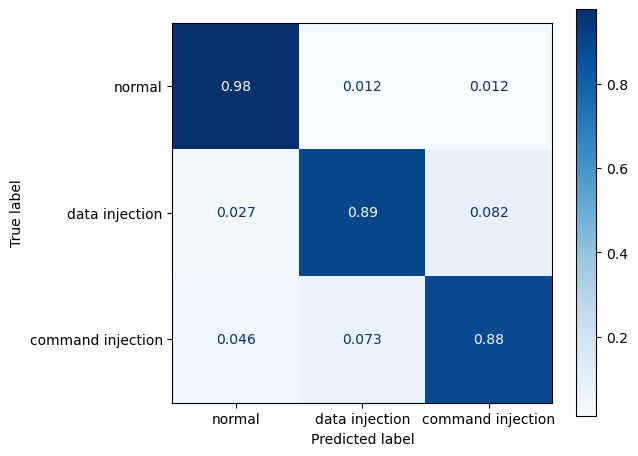

In [32]:
# create & export confusion matrix plot from the predictions generated using 5-fold cross-prediction
ConfusionMatrixDisplay.from_predictions(y_train['marker'], predicted, normalize='true', include_values=True, cmap='Blues', display_labels=['normal', 'data injection','command injection'])
plt.tight_layout()
plt.savefig('img/confusion-multi.pdf', format="pdf")